In [33]:
!pip install tensorflow==2.8.0rc0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.2/492.2 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 952.8/952.8 kB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 56.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 74.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 91.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 56.6 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard

This code demonstrates how RL with Q-Learning can be used to train an agent to make buy/sell decisions in a simulated financial trading environment.

In [34]:
import os
import math
import random
import numpy as np
import pandas as pd
from pylab import plt, mpl
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
np.set_printoptions(precision=4, suppress=True)
os.environ['PYTHONHASHSEED'] = '0'
%config InlineBackend.figure_format = 'svg'

In [35]:
import warnings as w
w.simplefilter('ignore')

In [36]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '4'

In [37]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [38]:
import tensorflow as tf
tf.__version__

'2.15.0'

In [39]:
import keras
keras.__version__

'2.15.0'

In [40]:
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
from sklearn.metrics import accuracy_score

In [54]:
import tensorflow as tf
if not tf.config.list_physical_devices('GPU'):  # Check for GPU availability
  print("Installing TensorFlow for GPU support...")
  !pip install tensorflow-gpu  # Install TensorFlow with GPU support
else:
  print("TensorFlow is already installed with GPU support.")

Installing TensorFlow for GPU support...
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
  Running setup.py clean for tensorflow-gpu
Failed to build tensorflow-gpu
ERROR: Could not build wheels for tensorflow-gpu, which is required to install pyproject.toml-based projects


Set a fixed seed for various libraries to ensure the experiment is reproducible and results are consistent across runs.

In [41]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    env.seed(seed)
    env.action_space.seed(100)

# Q-Learning

This class defines the core RL agent using Q-Learning.

It initializes parameters like gamma (discount factor) = 0.95, hidden units in the neural network model = 24, optimizer = Adam, learning rate = 0.001, epsilon day rate = 0.995, batch size = 32.

The '_build_model' function defines the neural network architecture with two hidden layers and an output layer with size equal to the number of available actions (buy or sell in this case).

The 'act' function decides the action based on epsilon-greedy policy. It explores randomly with epsilon probability and exploits the model's prediction with 1-epsilon probability.

The 'replay' function samples a mini-batch of experiences from memory and replays them to update the Q-values of the model using target Q-learning.

The 'learn' function trains the agent over a specified number of episodes. It interacts with the environment, stores experiences in memory, and replays them to learn. It tracks average rewards and prints progress.

The 'test' function in the DQLAgent class is designed to evaluate the performance of the trained agent on the environment.

In [42]:
from collections import deque

In [43]:
class DQLAgent:

    def __init__(self, gamma=0.95, hu=24, opt=keras.optimizers.Adam,
           lr=0.001, finish=False):
        self.finish = finish
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.gamma = gamma
        self.batch_size = 32
        self.max_treward = 0
        self.averages = list()
        self.memory = deque(maxlen=2000)
        self.osn = env.observation_space.shape[0]
        self.model = self._build_model(hu, opt, lr)

    def _build_model(self, hu, opt, lr):
        model = Sequential()
        model.add(Dense(hu, input_dim=self.osn,
                        activation='relu'))
        model.add(Dense(hu, activation='relu'))
        model.add(Dense(env.action_space.n, activation='linear'))
        model.compile(loss='mean_squared_error', optimizer=opt(learning_rate=lr))
        return model

    def act(self, state):
        if random.random() <= self.epsilon:
            return env.action_space.sample()
        action = self.model.predict(state)[0]
        return np.argmax(action)

    def replay(self):
        batch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in batch:
            if not done:
                reward += self.gamma * np.amax(
                    self.model.predict(next_state)[0])
            target = self.model.predict(state)
            target[0, action] = reward
            self.model.fit(state, target, epochs=1,
                           verbose=False)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def learn(self, episodes):
        trewards = []
        for e in range(1, episodes + 1):
            state = env.reset()
            state = np.reshape(state, [1, self.osn])
            for _ in range(5000):
                action = self.act(state)
                next_state, reward, done, info = env.step(action)
                next_state = np.reshape(next_state,
                                        [1, self.osn])
                self.memory.append([state, action, reward,
                                     next_state, done])
                state = next_state
                if done:
                    treward = _ + 1
                    trewards.append(treward)
                    av = sum(trewards[-25:]) / 25
                    self.averages.append(av)
                    self.max_treward = max(self.max_treward, treward)
                    templ = 'episode: {:4d}/{} | treward: {:4d} | '
                    templ += 'av: {:6.1f} | max: {:4d}'
                    print(templ.format(e, episodes, treward, av,
                                       self.max_treward), end='\r')
                    break
            if av > 195 and self.finish:
                break
            if len(self.memory) > self.batch_size:
                self.replay()
        print()

    def test(self, episodes):
        trewards = []
        for e in range(1, episodes + 1):
            state = env.reset()
            for _ in range(5001):
                state = np.reshape(state, [1, self.osn])
                action = np.argmax(self.model.predict(state)[0])
                next_state, reward, done, info = env.step(action)
                state = next_state
                if done:
                    treward = _ + 1
                    trewards.append(treward)
                    print('episode: {:4d}/{} | treward: {:4d}'
                          .format(e, episodes, treward), end='\r')
                    break
        return trewards

# Environment for Finance

This class defines the simulated financial trading environment.

It downloads historical data for a specific symbol (EUR=) and features (price or log return).

It preprocesses the data by normalizing it and creating a binary classification target indicating price increase/decrease.

The '_get_state' function retrieves the relevant features for the current state.

The 'reset' function initializes the environment for a new episode.

The 'step' function takes an action (buy or sell) and simulates the next step. It provides reward based on the action matching the target, updates internal variables, and determines if the episode is done.


In [44]:
class observation_space:
    def __init__(self, n):
        self.shape = (n,)

In [45]:
class action_space:
    def __init__(self, n):
        self.n = n
    def seed(self, seed):
        random.seed(seed)
    def sample(self):
        return random.randint(0, self.n - 1)

In [46]:
class Finance:

    url = 'http://hilpisch.com/aiif_eikon_eod_data.csv'

    def __init__(self, symbol, features):
        self.symbol = symbol
        self.features = features
        self.observation_space = observation_space(4)
        self.osn = self.observation_space.shape[0]
        self.action_space = action_space(2)
        self.min_accuracy = 0.475
        self._get_data()
        self._prepare_data()

    def _get_data(self):
        self.raw = pd.read_csv(self.url, index_col=0,
                               parse_dates=True).dropna()

    def _prepare_data(self):
        self.data = pd.DataFrame(self.raw[self.symbol])
        self.data['r'] = np.log(self.data / self.data.shift(1))
        self.data.dropna(inplace=True)
        self.data = (self.data - self.data.mean()) / self.data.std()
        self.data['d'] = np.where(self.data['r'] > 0, 1, 0)

    def _get_state(self):
        return self.data[self.features].iloc[
            self.bar - self.osn:self.bar].values

    def seed(self, seed=None):
        pass

    def reset(self):
        self.treward = 0
        self.accuracy = 0
        self.bar = self.osn
        state = self.data[self.features].iloc[
            self.bar - self.osn:self.bar]
        return state.values

    def step(self, action):
        correct = action == self.data['d'].iloc[self.bar]
        reward = 1 if correct else 0
        self.treward += reward
        self.bar += 1
        self.accuracy = self.treward / (self.bar - self.osn)
        if self.bar >= len(self.data):
            done = True
        elif reward == 1:
            done = False
        elif (self.accuracy < self.min_accuracy and
              self.bar > self.osn + 10):
            done = True
        else:
            done = False
        state = self._get_state()
        info = {}
        return state, reward, done, info

Two environments are created, one using price as the feature and another using log return.

An agent is created with specific hyperparameters (gamma, optimizer).

The agent learns for a set number of episodes (300) by interacting with the environment.

The agent's epsilon value (exploration vs exploitation) is printed after training.

The agent is tested for 3 episodes to evaluate its performance.

Finally, a plot is generated showing the moving average and regression line of the total rewards achieved during training.

In [47]:
env = Finance('EUR=', 'EUR=')  # price as feature
env = Finance('EUR=', 'r')  # log return as feature

In [48]:
env.reset()

array([-0.5125,  0.5603, -1.1434,  1.1788])

In [49]:
a = env.action_space.sample()
a

0

In [50]:
env.step(a)

(array([ 0.5603, -1.1434,  1.1788,  1.2569]), 0, False, {})

In [55]:
set_seeds(100)
agent = DQLAgent(gamma=0.5, opt=tf.compat.v1.train.AdamOptimizer)

In [52]:
episodes = 300

In [ ]:
!pip install keras-tuner
from tensorflow import keras
from kerastuner import HyperParameters
def learn(self, episodes):
    for episode in range(episodes):
        state = self.env.reset()
        state = np.reshape(state, [1, self.state_size])
        done = False
        score = 0
        while not done:
            action = self.act(state)
            next_state, reward, done, _ = self.env.step(action)
            next_state = np.reshape(next_state, [1, self.state_size])
            self.memory.append([state, action, reward, next_state, done])
            state = next_state
            score += reward
            if done:
                print("Episode: {}/{}, Score: {}".format(episode, episodes, score))
                break
        if len(self.memory) > self.batch_size:
            self.replay()
def replay(self):
    minibatch = random.sample(self.memory, self.batch_size)
    for state, action, reward, next_state, done in minibatch:
        target = self.model.predict(state)
        if done:
            target[0][action] = reward
        else:
            Q_future = max(self.model.predict(next_state)[0])
            target[0][action] = reward + Q_future * self.gamma
        self.model.fit(state, target, epochs=1, verbose=0)

In [56]:
%time agent.learn(episodes)


CPU times: user 5min 5s, sys: 6.71 s, total: 5min 11s
Wall time: 5min 6s


In [57]:
agent.epsilon

0.22453190559909803

In [58]:
agent.test(3)

[2511, 2511, 2511]

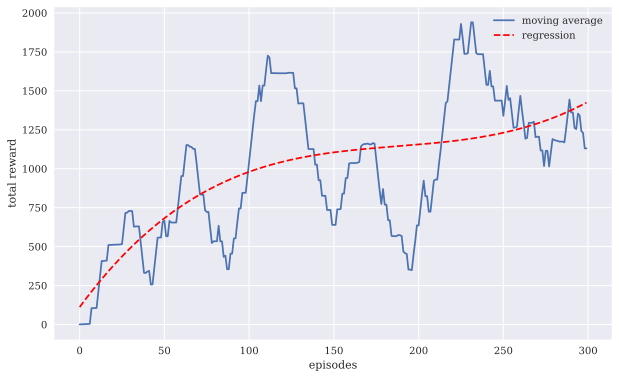

In [59]:
plt.figure(figsize=(10, 6))
x = range(len(agent.averages))
y = np.polyval(np.polyfit(x, agent.averages, deg=3), x)
plt.plot(agent.averages, label='moving average')
plt.plot(x, y, 'r--', label='regression')
plt.xlabel('episodes')
plt.ylabel('total reward')
plt.legend();